### **Getting data**

In [1]:
from data.data_loader import get_data
import tensorflow as tf

In [2]:
import warnings
warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
seed = 0
train_tensor, validation_tensor, test_tensor = get_data(selected_fold=1, seed=seed)

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

training_data = train_tensor.cache().shuffle(961).prefetch(buffer_size=AUTOTUNE)
validation_data = validation_tensor.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_tensor.cache().prefetch(buffer_size=AUTOTUNE)

### **Training model**

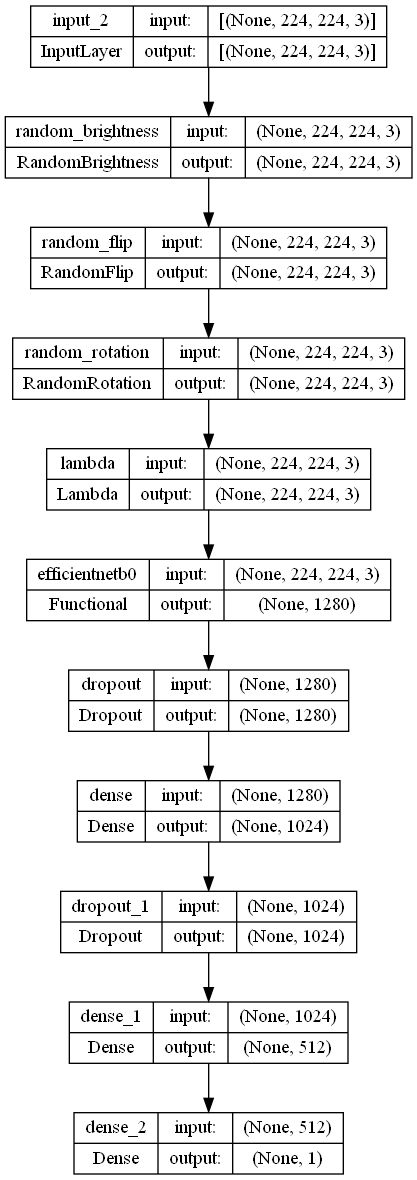

In [5]:
from efficient import EfficientNet

model = EfficientNet(img_dimension=224)
tf.keras.utils.plot_model(model.model, to_file='./raw_models/efficient_topology.png', show_shapes=True)

In [6]:
model.model.summary()

Model: "EfficientNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_brightness (RandomBr  (None, 224, 224, 3)      0         
 ightness)                                                       
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dropout (Dropout)           (None, 1280)             

In [7]:
model.fit(
    training_data,
    validation_data,
    learning_rate=0.01,
    patience=5,
    epochs=1000,
    verbose=1
)

Epoch 1/1000
29/29 [==============================] - 51s 1s/step - loss: 2.1137 - roc_auc: 0.5683 - binary_accuracy: 0.5547 - val_loss: 0.5954 - val_roc_auc: 0.7683 - val_binary_accuracy: 0.7351 - lr: 0.0100
Epoch 2/1000
29/29 [==============================] - 39s 1s/step - loss: 0.5709 - roc_auc: 0.7771 - binary_accuracy: 0.7102 - val_loss: 0.5334 - val_roc_auc: 0.8346 - val_binary_accuracy: 0.7873 - lr: 0.0100
Epoch 3/1000
29/29 [==============================] - 38s 1s/step - loss: 0.5327 - roc_auc: 0.8120 - binary_accuracy: 0.7388 - val_loss: 0.5342 - val_roc_auc: 0.8609 - val_binary_accuracy: 0.7276 - lr: 0.0100
Epoch 4/1000
29/29 [==============================] - 39s 1s/step - loss: 0.4895 - roc_auc: 0.8458 - binary_accuracy: 0.7711 - val_loss: 0.5236 - val_roc_auc: 0.8717 - val_binary_accuracy: 0.7313 - lr: 0.0100
Epoch 5/1000
29/29 [==============================] - 38s 1s/step - loss: 0.5013 - roc_auc: 0.8409 - binary_accuracy: 0.7612 - val_loss: 0.6144 - val_roc_auc: 0.881

In [8]:
model.save_model('efficient')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\functional
......vars
...layers\functional\layers\activation
......vars
...layers\functional\layers\activation_1
......vars
...layers\functional\layers\activation_10
......vars
...layers\functional\layers\activation_11
......vars
...layers\functional\layers\activation_12
......vars
...layers\functional\layers\activation_13
......vars
...layers\functional\layers\activation_14
......vars
...layers\functional\layers\activation_15
......vars
...layers\functional\layers\activation_16
......vars
...layers\functional\layers\activation_17
......vars
...layers\functional\layers\activation_18
......vars
...layers\functional\layers\activation_19
......vars
...layers\functional\layers\activation_2
......vars
...laye

In [9]:
y_true, y_pred = model.predict(test_data)

In [10]:
import numpy as np

y_probas_efficient = np.column_stack((1 - y_pred, y_pred))

In [11]:
from plots import plot_target_vs_score

In [12]:
plot_target_vs_score(y_true, y_pred, quantiles=10)

In [13]:
plot_target_vs_score(y_true, y_pred, quantiles=100, lower_limit=90)

In [14]:
loss, auc, accuracy = model.evaluate(test_data, verbose=1)
loss, auc, accuracy

50/50 [==============================] - 50s 993ms/step - loss: 0.3879 - roc_auc: 0.8991 - binary_accuracy: 0.8377


(0.3879203498363495, 0.8990787863731384, 0.8377412557601929)

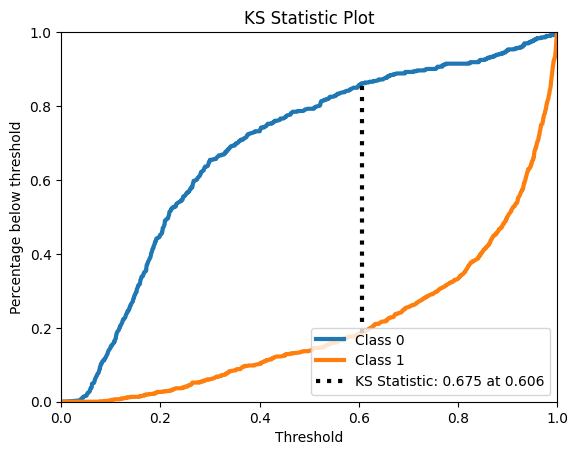

In [15]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_ks_statistic(y_true=y_true, y_probas=y_probas_efficient)
plt.show()

In [16]:
from sklearn import metrics

results = [(labels, model.model.predict(images).reshape(-1)) for images, labels in test_data.take(-1)]

1/1 [==============================] - 1s 1s/step


##### Other metrics

In [17]:
labels = np.concatenate([x[0] for x in results])
preds = np.concatenate([x[1] for x in results])

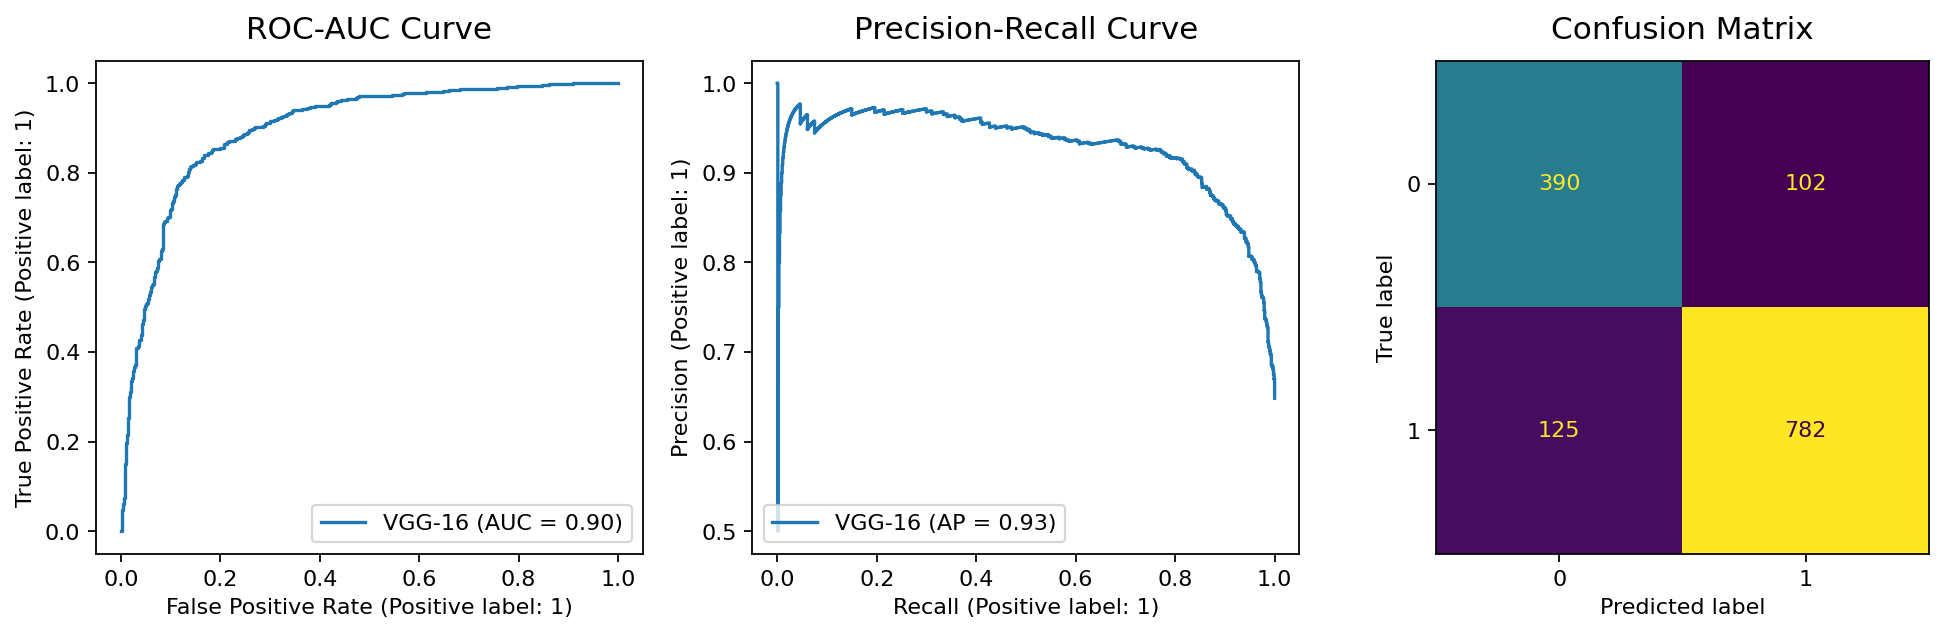

In [18]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4), dpi=160)
curves = [metrics.RocCurveDisplay, metrics.PrecisionRecallDisplay]
for ax, curve in zip(axes[:2], curves):
    curve.from_predictions(labels, preds, ax=ax, name='VGG-16')
metrics.ConfusionMatrixDisplay.from_predictions(
    labels, preds.round().astype('uint8'), ax=axes[2], colorbar=False,
)
titles = ['ROC-AUC Curve', 'Precision-Recall Curve', 'Confusion Matrix']
for ax, title in zip(axes.flat, titles):
    ax.set_title(title, size=14, pad=10)